In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    nonstationaryDGP, 
    FeatureEngineering
)

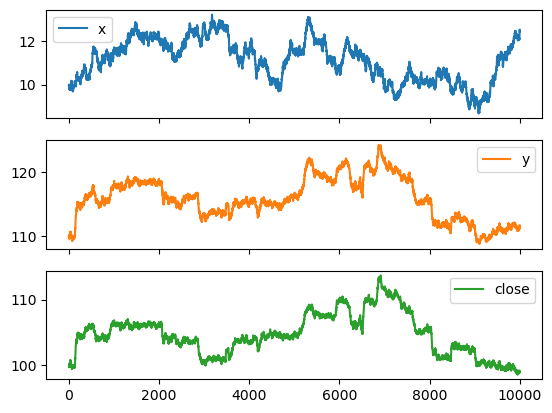

In [2]:
x, y = nonstationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [3]:
# confirm the x, y pair is not cointegrated
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     830.6
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.58e-175
Time:                        23:13:01   Log-Likelihood:                -25609.
No. Observations:               10000   AIC:                         5.122e+04
Df Residuals:                    9998   BIC:                         5.124e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.4116      0.363    290.444      0.0

In [4]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -1.7700605855263838
p-value: 0.3954237850453966
Is the spread stationary? No


In [5]:
# build features
df_train = df.copy()

feature_config = {
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "diff", # difference between current and previous close price
    "subtract_mean": True,
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,9.965975,109.837898,99.871923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.971701,109.963545,99.991843,0.059960,-0.059960,-0.059960,-0.059960,-0.059960,-0.059960,-0.059960
2,10.002110,110.068336,100.066226,0.009615,0.055153,-0.064768,-0.064768,-0.064768,-0.064768,-0.064768
3,9.925394,110.042870,100.117476,-0.010139,0.012995,0.058532,-0.061388,-0.061388,-0.061388,-0.061388
4,9.851801,110.025521,100.173720,-0.004116,-0.009110,0.014024,0.059561,-0.060359,-0.060359,-0.060359
...,...,...,...,...,...,...,...,...,...,...
9995,12.529054,111.690175,99.161120,-0.056986,-0.049103,0.204824,0.039934,0.012933,-0.111210,-0.040393
9996,12.518737,111.480368,98.961631,-0.200355,-0.030326,-0.022442,0.231484,0.066594,0.039594,-0.084549
9997,12.514282,111.563801,99.049519,0.062513,-0.224865,-0.054836,-0.046953,0.206974,0.042084,0.015083
9998,12.484843,111.490170,99.005326,-0.057475,0.074606,-0.212772,-0.042743,-0.034860,0.219067,0.054177


In [6]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0) # always short position

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Market Return : -0.89%   |   Portfolio Return :  0.88%   |   Position Changes : 1   |   Episode Length : 10000   |   


In [7]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return : -0.89%   |   Portfolio Return : -56.47%   |   Position Changes : 5726   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -44.04%   |   Position Changes : 5271   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -36.11%   |   Position Changes : 5137   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -33.11%   |   Position Changes : 5078   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -42.34%   |   Position Changes : 4889   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -36.18%   |   Position Changes : 4853   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -38.19%   |   Position Changes : 4914   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -34.08%   |   Position Changes : 4705   |   Episode Length : 10000   |   
Market Return : -0.89%  

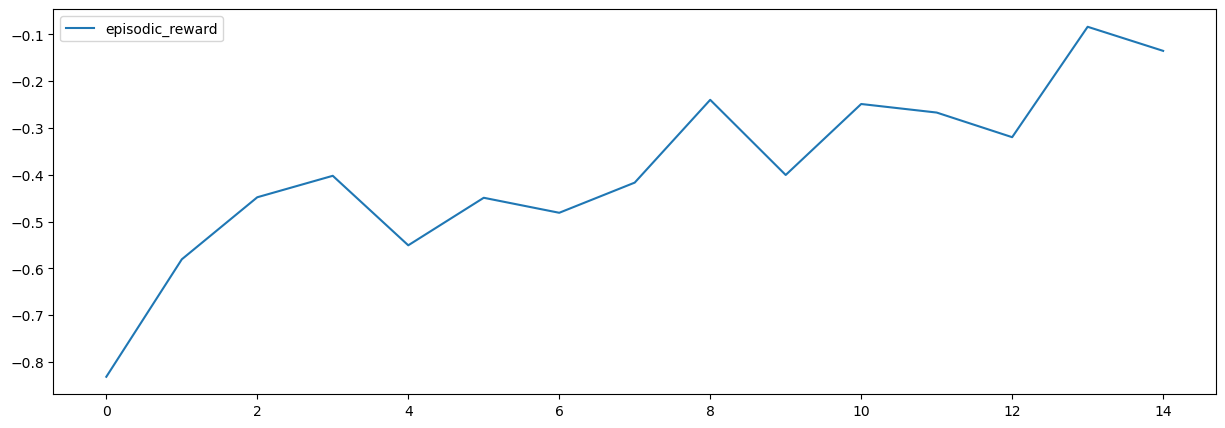

In [8]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [9]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = nonstationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df, main_feature_col="close")
    fe.rolling_feature(**feature_config)
    _df = fe.df.copy()
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  2.98%   |   Portfolio Return : -57.47%   |   Position Changes : 4770   |   Episode Length : 10000   |   
Market Return : -6.47%   |   Portfolio Return : -61.32%   |   Position Changes : 4693   |   Episode Length : 10000   |   
Market Return : -12.00%   |   Portfolio Return : -60.93%   |   Position Changes : 4840   |   Episode Length : 10000   |   
Market Return :  4.10%   |   Portfolio Return : -55.96%   |   Position Changes : 4790   |   Episode Length : 10000   |   
Market Return :  2.64%   |   Portfolio Return : -62.67%   |   Position Changes : 4697   |   Episode Length : 10000   |   
Market Return :  4.88%   |   Portfolio Return : -58.19%   |   Position Changes : 4731   |   Episode Length : 10000   |   
Market Return : -13.30%   |   Portfolio Return : -62.51%   |   Position Changes : 4785   |   Episode Length : 10000   |   
Market Return : -16.08%   |   Portfolio Return : -56.73%   |   Position Changes : 4740   |   Episode Length : 10000   |   
Market Return : -30.6

In [10]:
# build features
df_train = df.copy()

feature_config = {
    "window": 100, # 7 days window, pad with first value when window is not available
    "mode": "diff", # difference between current and previous close price
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_mean_corrected_feature(**feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_rolling_mean_corrected
0,9.965975,109.837898,99.871923,0.000000
1,9.971701,109.963545,99.991843,0.059960
2,10.002110,110.068336,100.066226,0.009615
3,9.925394,110.042870,100.117476,-0.010139
4,9.851801,110.025521,100.173720,-0.004116
...,...,...,...,...
9995,12.529054,111.690175,99.161120,-0.025336
9996,12.518737,111.480368,98.961631,-0.192887
9997,12.514282,111.563801,99.049519,0.092151
9998,12.484843,111.490170,99.005326,-0.039321


In [11]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0) # always short position

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 1. 1.]
Market Return : -0.89%   |   Portfolio Return :  0.87%   |   Position Changes : 1   |   Episode Length : 10000   |   


In [12]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return : -0.89%   |   Portfolio Return : -60.44%   |   Position Changes : 6653   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -58.74%   |   Position Changes : 6654   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -51.12%   |   Position Changes : 4926   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -45.95%   |   Position Changes : 4999   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -19.15%   |   Position Changes : 3236   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -41.01%   |   Position Changes : 3190   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -13.83%   |   Position Changes : 2013   |   Episode Length : 10000   |   
Market Return : -0.89%   |   Portfolio Return : -16.76%   |   Position Changes : 1951   |   Episode Length : 10000   |   
Market Return : -0.89%  

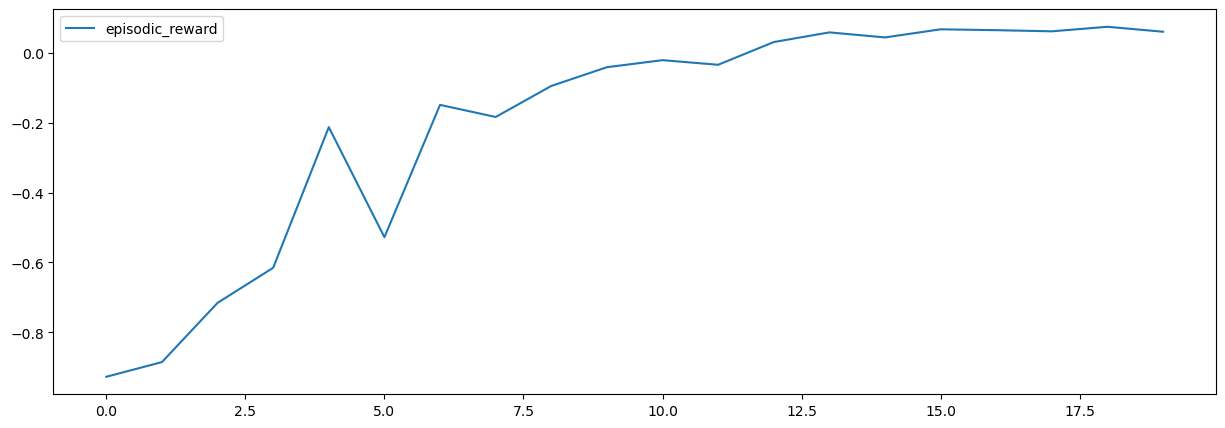

In [13]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [15]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = nonstationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df, main_feature_col="close")
    fe.rolling_mean_corrected_feature(**feature_config)
    _df = fe.df.copy()
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  8.90%   |   Portfolio Return : -5.29%   |   Position Changes : 773   |   Episode Length : 10000   |   
Market Return : -11.70%   |   Portfolio Return : -6.90%   |   Position Changes : 810   |   Episode Length : 10000   |   
Market Return : -16.33%   |   Portfolio Return : -10.54%   |   Position Changes : 765   |   Episode Length : 10000   |   
Market Return : -13.15%   |   Portfolio Return : -2.51%   |   Position Changes : 783   |   Episode Length : 10000   |   
Market Return : -5.31%   |   Portfolio Return : -11.60%   |   Position Changes : 789   |   Episode Length : 10000   |   
Market Return :  8.35%   |   Portfolio Return : -14.85%   |   Position Changes : 782   |   Episode Length : 10000   |   
Market Return : 22.10%   |   Portfolio Return : -5.94%   |   Position Changes : 727   |   Episode Length : 10000   |   
Market Return :  2.16%   |   Portfolio Return : -10.63%   |   Position Changes : 792   |   Episode Length : 10000   |   
Market Return : 21.21%   |   Port